In [2]:
import numpy as np, torch, gpytorch, matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
torch.set_default_dtype(torch.float32)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. PORTFOLIO SPECIFICATION
### 1.1  Underlying processes


In [3]:
# Market & model parameters
r           = 0.01               # OIS flat
T           = 1.0                # horizon (years)
dt          = 1/12               # monthly step
Nsteps      = int(T/dt)+1
times       = np.linspace(0,T,Nsteps)

# Three GBM factors: S1, S2 (equities) & R (FX EUR/USD)
S0_1, S0_2, R0 = 100., 120., 1.10
sig1,  sig2,  sigR = 0.20, 0.25, 0.15
mu1,   mu2,   muR  = r, r, r      # risk‑neutral drift

rho12, rho1R, rho2R = 0.6, 0.4, 0.35          # corr. matrix entries
cov = np.array([[1,       rho12, rho1R],
                [rho12,   1,     rho2R],
                [rho1R,   rho2R, 1       ]])
L = np.linalg.cholesky(cov)


### 1.2 Derivatives in the Portfolio

- **D1**: Call on $S_1$, strike $K_1 = 100$  
- **D2**: Put on $S_2$, strike $K_2 = 120$  
- **D3**: Exchange option “$S_1$ vs. $S_2$” (Margrabe) – payoff $\max(S_1 - \kappa S_2, 0)$ with $\kappa = 1$

Weights $w = (1, 1, 1)$ ⇒ portfolio value:

$$
\pi(t,\mathbf{X}_t) = w_1 C_{S_1} + w_2 P_{S_2} + w_3 X_{12}
$$


In [4]:
K1, K2, kappa = 100., 120., 1.0
w = np.ones(3)                       # weights

def bs_call(S,K,vol,tau):            # Black–Scholes european call (risk‑neutral, no div)
    d1 = (np.log(S/K)+(r+0.5*vol**2)*tau)/(vol*np.sqrt(tau))
    d2 = d1-vol*np.sqrt(tau)
    return S*norm.cdf(d1)-K*np.exp(-r*tau)*norm.cdf(d2)

def bs_put(S,K,vol,tau):
    return bs_call(S,K,vol,tau)-S+K*np.exp(-r*tau)

def margrabe(S1,S2,sigma1,sigma2,rho,tau,kappa=1.0):
    sig = np.sqrt(sigma1**2 + kappa**2*sigma2**2 - 2*kappa*rho*sigma1*sigma2)
    d1  = (np.log(S1/(kappa*S2)) + 0.5*sig**2*tau)/(sig*np.sqrt(tau))
    d2  = d1 - sig*np.sqrt(tau)
    return np.exp(-r*tau)*(S1*norm.cdf(d1) - kappa*S2*norm.cdf(d2))


In [5]:
Mpaths = 4000                       # outer Monte‑Carlo
np.random.seed(2025)
# containers
S1 = np.zeros((Mpaths,Nsteps)); S2 = np.zeros_like(S1); RFX = np.zeros_like(S1)
S1[:,0]=S0_1; S2[:,0]=S0_2; RFX[:,0]=R0

# Brownian increments
dW = multivariate_normal.rvs(mean=np.zeros(3),
                             cov=cov,
                             size=(Mpaths,Nsteps-1))

for i in range(1,Nsteps):
    Z = dW[:,i-1,:]                        # shape (M,3)
    S1[:,i] = S1[:,i-1]*np.exp((mu1-0.5*sig1**2)*dt + sig1*np.sqrt(dt)*Z[:,0])
    S2[:,i] = S2[:,i-1]*np.exp((mu2-0.5*sig2**2)*dt + sig2*np.sqrt(dt)*Z[:,1])
    RFX[:,i]= RFX[:,i-1]*np.exp((muR-0.5*sigR**2)*dt + sigR*np.sqrt(dt)*Z[:,2])


### 2.1  Stochastic intensity & default time (Cox process)
We impose 
$$
\gamma_t=\gamma_0\bigl(S_{1,0}/S_{1,t}\bigr)^\eta
$$
with $$ \gamma_0=0.2,\; \eta=1.3\ $$  
Intégration discrète → tirage de $ \tau $ par **méthode du temps d’arrivée conditionnel**.


In [6]:
gamma0, eta = 0.2, 1.3
Gamma   = gamma0 * (S0_1 / S1)**eta          # (M, Nsteps)
Lambda  = np.cumsum(Gamma[:,:-1]*dt, axis=1) # sommation gauche

U = np.random.rand(Mpaths)
tau_index = np.full(Mpaths, Nsteps, dtype=int)     # défaut après horizon par défaut
for m in range(Mpaths):
    hit = np.where(Lambda[m] >= -np.log(U[m]))[0]
    if hit.size:
        tau_index[m] = hit[0] + 1                 # +1 car Lambda est à Nsteps‑1

mask_default = tau_index < Nsteps                 # défaut effectif

tau_realized = np.full(Mpaths, np.inf)            # étape robuste
tau_realized[mask_default] = times[tau_index[mask_default]]

**Visualiser la densité de défaut et la courbe de survie :**

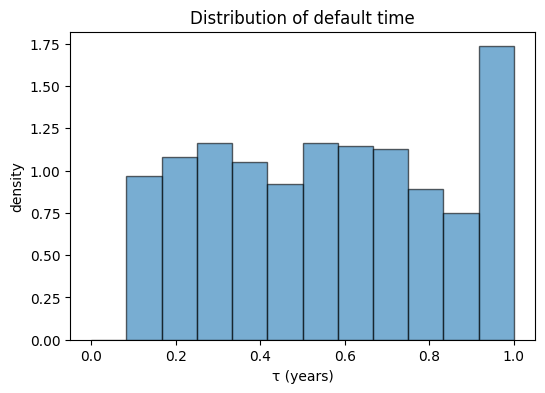

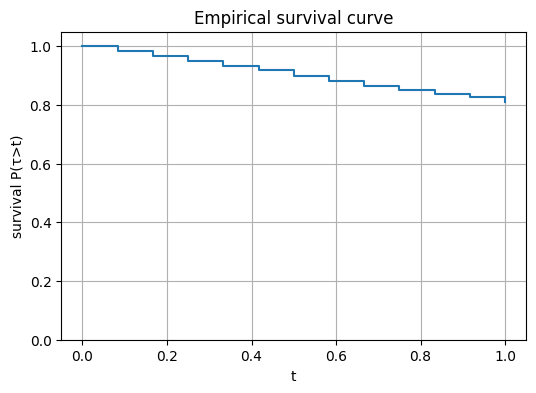

In [7]:
# ---------- visuels ----------
plt.figure(figsize=(6,4))
plt.hist(tau_realized[mask_default],
         bins=np.arange(0, T+dt, dt),
         density=True, alpha=.6, edgecolor='k')
plt.xlabel("τ (years)"); plt.ylabel("density")
plt.title("Distribution of default time"); plt.show()

surv = [np.mean(tau_realized > t) for t in times]
plt.figure(figsize=(6,4))
plt.step(times, surv, where='post')
plt.xlabel("t"); plt.ylabel("survival P(τ>t)")
plt.title("Empirical survival curve"); plt.ylim(0,1.05); plt.grid(); plt.show()


In [8]:
default_rate = np.mean(tau_realized < T)
print(f"Proportion de défauts avant T = {default_rate:.2%}")


Proportion de défauts avant T = 17.38%


**EXPOSITIONS & CVA MONTE‑CARLO**

In [9]:
prices = np.zeros((Mpaths, Nsteps, 3))  # prix exacts des 3 produits
for i, t in enumerate(times):
    prices[:, i, 0] = bs_call(S1[:, i], K1, sig1, T - t)
    prices[:, i, 1] = bs_put (S2[:, i], K2, sig2, T - t)
    prices[:, i, 2] = margrabe(S1[:, i], S2[:, i], sig1, sig2, rho12, T - t, kappa)

/var/folders/bl/500x18v50xz3zwzx4p286wqw0000gn/T/ipykernel_1006/1357189328.py:5: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S/K)+(r+0.5*vol**2)*tau)/(vol*np.sqrt(tau))
/var/folders/bl/500x18v50xz3zwzx4p286wqw0000gn/T/ipykernel_1006/1357189328.py:14: RuntimeWarning: divide by zero encountered in divide
  d1  = (np.log(S1/(kappa*S2)) + 0.5*sig**2*tau)/(sig*np.sqrt(tau))


In [10]:
portfolio = prices @ w               # valeur du portefeuille pour chaque path/date
exposure = np.maximum(portfolio, 0) # exposition positive

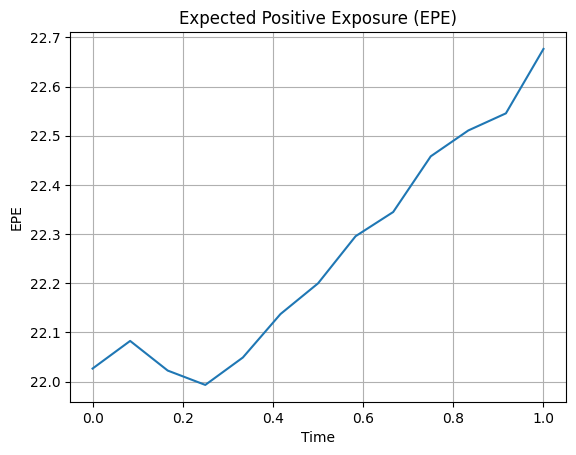

In [11]:
EPE = np.mean(exposure, axis=0)
plt.plot(times, EPE)
plt.title("Expected Positive Exposure (EPE)")
plt.xlabel("Time")
plt.ylabel("EPE")
plt.grid(); plt.show()

In [12]:
print("EPE moyenne :", np.mean(exposure))
print("Probabilité de défaut avant T :", np.mean(tau_realized < T))
print("LGD :", 1 - 0.4)
print("CVA approximative analytique :", 0.6 * np.mean(exposure) * np.mean(tau_realized < T))

EPE moyenne : 22.257129763466136
Probabilité de défaut avant T : 0.17375
LGD : 0.6
CVA approximative analytique : 2.3203057778413445


In [13]:
default_mask = np.zeros((Mpaths, Nsteps), dtype=bool)

# Pour chaque trajectoire, trouver l'index i tel que t_{i-1} < tau <= t_i
tau_idx = np.searchsorted(times, tau_realized, side='right')

# Marquer l'instant du défaut
for m in range(Mpaths):
    if tau_idx[m] < Nsteps:
        default_mask[m, tau_idx[m]] = True


In [14]:
CVA_MC = 0.0
disc = np.exp(-r * times)

for i in range(1, Nsteps):  # on ignore t=0
    mask = default_mask[:, i]
    if np.any(mask):  # au moins un défaut à t_i
        exposure_at_default = exposure[mask, i]
        CVA_MC += (1 - 0.4) * np.sum(exposure_at_default) * disc[i] / Mpaths


In [15]:
CVA_MC

2.2630894384513427

### 4. METAMODEL : ENTRAÎNEMENT D’UN MGP GPyTorch
### 4.1  Jeu d’entraînement (maillage LHS sur (S1,S2,t))

In [17]:
def price_vectorized(S1, S2, t):
    """
    Calcule les prix des 3 produits (call, put, margrabe) du portefeuille
    pour un vecteur d'états de marché (S1, S2, t).
    """
    tau = T - t  
    c1 = bs_call(S1, K1, sig1, tau)
    p2 = bs_put(S2, K2, sig2, tau)
    x  = margrabe(S1, S2, sig1, sig2, rho12, tau, kappa)
    
    return np.column_stack((c1, p2, x))

In [18]:
from pyDOE import lhs  # latin hypercube
Ntrain = 3000

lhs_raw = lhs(3, samples=Ntrain)  # (t, S1, S2)
t_grid  = T      * lhs_raw[:,0]
S1_grid = S0_1 * (0.5 + 1.5 * lhs_raw[:,1])   # [50,250]
S2_grid = S0_2 * (0.5 + 1.5 * lhs_raw[:,2])

# évaluation exacte sur ces points
Y_train = price_vectorized(S1_grid, S2_grid, t_grid)

# input = (t, S1, S2)  --> cohérent avec flat_inputs
X_train = np.column_stack((t_grid, S1_grid, S2_grid))

# tensors
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(Y_train, dtype=torch.float32)

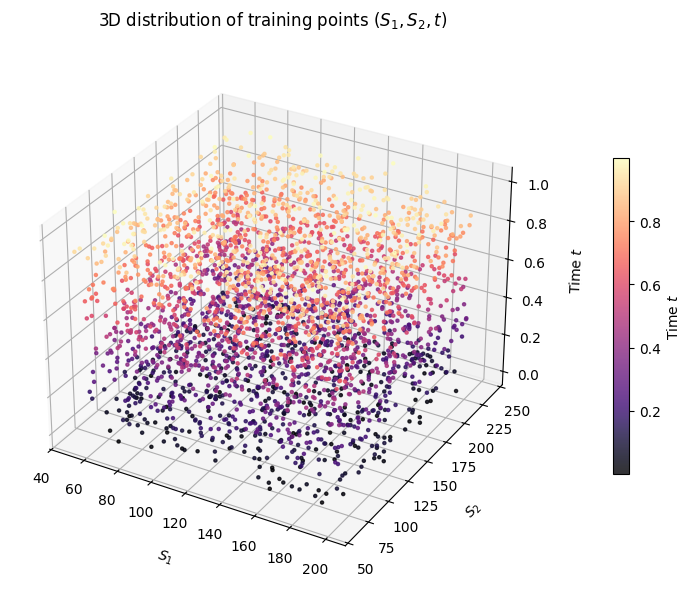

In [19]:
# 3D display of training design
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(S1_grid, S2_grid, t_grid, 
                     c=t_grid, cmap='magma', s=5, alpha=0.8)

# Axis labels and title
ax.set_xlabel("$S_1$", labelpad=10)
ax.set_ylabel("$S_2$", labelpad=10)
ax.set_zlabel("Time $t$", labelpad=10)
ax.set_title("3D distribution of training points $(S_1, S_2, t)$", pad=20)

# Add colorbar
cb = fig.colorbar(scatter, shrink=0.6, pad=0.1)
cb.set_label("Time $t$")

plt.tight_layout()
plt.show()


### 4.2  MGP : kernel RBF sur l’espace input (3D) + corrélation inter‑tâches Ω


In [ ]:
class MGP(gpytorch.models.ExactGP):
    def __init__(self, x, y, lik, num_tasks=3):
        super().__init__(x, y, lik)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            num_tasks=num_tasks, rank=1)
    

    def forward(self, x):
        return gpytorch.distributions.MultitaskMultivariateNormal(
            self.mean_module(x), self.covar_module(x))

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
model = MGP(train_x, train_y, likelihood, num_tasks=3)

model.train(); likelihood.train()
opt = torch.optim.Adam(model.parameters(), lr=0.08)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for it in range(120):
    opt.zero_grad()
    loss = -mll(model(train_x), train_y)
    loss.backward(); opt.step()
    if (it+1)%20 == 0:
        print(f"Iter {it+1}, NLL = {loss.item():.3f}")

model.eval(); likelihood.eval()

Iter 20, NLL = 48.361
Iter 40, NLL = 9.732
Iter 60, NLL = 5.892
Iter 80, NLL = 5.024
Iter 100, NLL = 4.588
Iter 120, NLL = 4.279


MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

### 5. PREDICTION SUR LES CHEMINS & CVA‑MGP


In [35]:
# (Mpaths, Nsteps) => (Mpaths * Nsteps, 3)
flat_inputs = torch.tensor(
    np.column_stack((
        np.repeat(times, Mpaths),   # t
        S1.flatten(),               # S1
        S2.flatten()                # S2
    )),
    dtype=torch.float32
)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(flat_inputs))

mean_pred = pred.mean.numpy().reshape(Nsteps, Mpaths, 3).transpose(1, 0, 2)
# shape: (Mpaths, Nsteps, 3)

In [ ]:
port_GP = mean_pred @ w
expo_GP = np.maximum(port_GP, 0)

# CVA GP
CVA_GP = 0.0
for i in range(1, Nsteps):
    mask = default_mask[:, i]
    if np.any(mask):
        exp_gp = expo_GP[mask, i]
        CVA_GP += (1 - 0.4) * np.sum(exp_gp) * disc[i] / Mpaths


print("CVA via MGP        =", CVA_GP)
print("Rel. error GP vs brute :", (CVA_GP - CVA_MC) / CVA_MC)

2.2586428988879934

CVA via MGP        = 2.2438327968375313
Rel. error GP vs brute : -0.008509006001543133


### 6. VISUALISATIONS COMPARATIVES


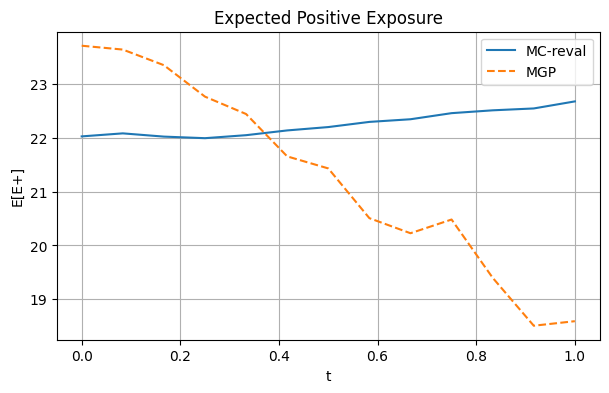

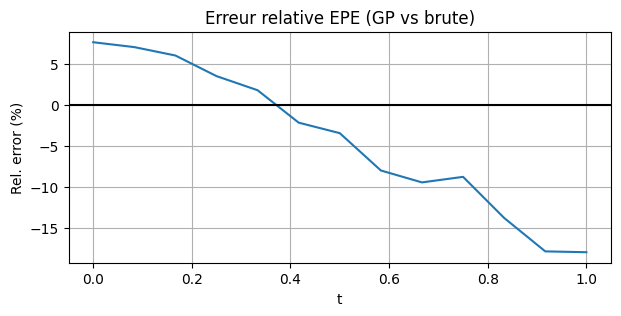

In [37]:
# 6.1 EPE profile true vs GP
EPE_true = np.mean(exposure, axis=0)
EPE_gp   = np.mean(expo_GP, axis=0)

plt.figure(figsize=(7,4))
plt.plot(times,EPE_true,label="MC‑reval")
plt.plot(times,EPE_gp,'--',label="MGP")
plt.xlabel("t"); plt.ylabel("E[E+]")
plt.title("Expected Positive Exposure")
plt.legend(); plt.grid(True); plt.show()

# 6.2 Erreur relative sur EPE
plt.figure(figsize=(7,3))
plt.plot(times, (EPE_gp-EPE_true)/EPE_true*100)
plt.xlabel("t"); plt.ylabel("Rel. error (%)")
plt.title("Erreur relative EPE (GP vs brute)")
plt.axhline(0,color='k'); plt.grid(True); plt.show()

### COMMENTAIRES & PERSPECTIVES
* **Qualité d’ajustement** : vérifier MSE par tâche (call/put/exchange).  
* **Sensibilité à Ntrain** : lancer un sweep (500→5000) et tracer l’erreur CVA.  
* **Quantification d’incertitude** : récupérer `pred.variance` pour bâtir bande de confiance sur EPE/CVA.  
* **Wrong‑way risk** : jouer sur $ \eta\ $ et montrer l’impact sur CVA et l’erreur GP.  
* **Greeks** : dériver la MGP pour exposer Deltas et tester Δ‑hedge sous défaut.


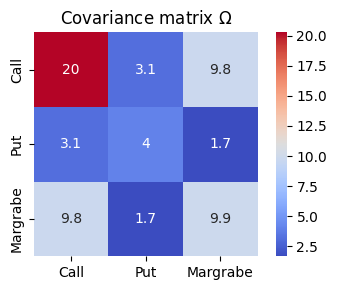

In [38]:
# Matrice de covariance inter-tâches (3x3)
Omega = model.covar_module.task_covar_module.covar_matrix.detach().numpy()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))
sns.heatmap(Omega, annot=True, cmap='coolwarm', square=True,
            xticklabels=["Call", "Put", "Margrabe"],
            yticklabels=["Call", "Put", "Margrabe"])
plt.title("Covariance matrix $\\Omega$")
plt.tight_layout()
plt.savefig("omega_cov_matrix.png")
plt.show()


In [39]:
# Longueurs d’échelle par dimension (t, S1, S2)
lengthscales = model.covar_module.data_covar_module.base_kernel.lengthscale.detach().cpu().numpy()

print("Longueurs d’échelle RBF (par dimension) :")
for dim, val in zip(["t", "S1", "S2"], lengthscales[0]):
    print(f"  {dim} : {val:.4f}")


Longueurs d’échelle RBF (par dimension) :
  t : 2.4677
  S1 : 3.6978
  S2 : 3.7067


In [41]:
import torch

# Exemple : calcul de Delta pour un point (t, S1, S2)
x_star = torch.tensor([[0.5, 110.0, 120.0]], requires_grad=True)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = model(x_star)
mean_pred = pred.mean  # (1, 3)

# Active le gradient sur l’entrée
x_star.requires_grad_(True)
out = model(x_star)
out.mean[:, 0].backward()  # par exemple, la dérivée du CALL

# Récupérer ∂/∂S1
delta = x_star.grad[0, 1].item()
print("Delta (∂Call/∂S1) =", delta)


Delta (∂Call/∂S1) = 0.9324125051498413
